# Install necessary packages

In [1]:
%pip install pandas numpy seaborn tensorflow matplotlib tensorflow_decision_forests joblib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

/tmp/ipykernel_68830/64076161.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-07 15:30:19.367391: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 15:30:19.442191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 15:30:19.442226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin c

### Load Models From CSV along Threshhold

In [4]:
def load_models_and_thresholds(csv_filename, filter_keyword):
    # Load model information from CSV
    model_info = pd.read_csv(csv_filename)

    # Filter models based on keyword
    filtered_models_info = model_info[model_info['ModelName'].str.contains(filter_keyword, case=False)]

    # Initialize an empty dictionary to store models and thresholds
    models_and_thresholds = {}

    # Loop through rows in the DataFrame
    for index, row in filtered_models_info.iterrows():
        model_filename = row['ModelName']
        threshold = row['Threshold']
        
        # Add the model and threshold to the dictionary
        models_and_thresholds[model_filename] = threshold

    return models_and_thresholds

Linear

In [5]:
def predict_linear_with_threshold_and_evaluate(X, y_val,model_filename, threshold, binary=True):
    # Load the model
    model = joblib.load(model_filename)

    # Make predictions
    y_pred_continuous = model.predict(X)

    # Convert predictions to binary using the specified threshold
    y_pred_binary = (y_pred_continuous > threshold).astype(int) if binary else y_pred_continuous

    # Evaluate the model
    roc_auc = roc_auc_score(y_val, y_pred_continuous)
    conf_matrix = confusion_matrix(y_val, y_pred_binary)
    classification_rep = classification_report(y_val, y_pred_binary)

    # Print evaluation results
    print(f'Model: {model_filename}')
    print(f'ROC AUC: {roc_auc:.2f}')
    print('Confusion Matrix:\n', conf_matrix)
    print('Classification Report:\n', classification_rep)

    # Plot the scatter plot with predicted probabilities and true labels for the testing set
    plt.figure(figsize=(12, 8))
    plt.scatter(range(len(y_val)), y_pred_continuous, c=np.where(y_val['Churn'].values == 1, 'red', 'green'), alpha=0.7)
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Best Threshold = {threshold:.4f}')
    plt.title(f'Scatter Plot of Continuous Predictions with Threshold and True Labels - {model_filename}')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Probability')
    plt.legend()
    plt.show()

    return y_pred_binary

Logistic

In [6]:
def predict_logistic_with_threshold_and_evaluate(X, y_val,model_filename, threshold=0.5, binary=True):
    # Load the model
    model = joblib.load(model_filename)
    try:
        y_pred_continuous = model.predict_proba(X)[:, 1]
    except:
        pass
    else:
        y_pred_continuous=model.decision_function(X)
        
    # Convert threshold to float
    threshold = float(threshold)

    y_pred_binary = (y_pred_continuous > threshold).astype(int) if binary else y_pred_continuous

    # Evaluate the model
    roc_auc = roc_auc_score(y_val, y_pred_continuous)
    conf_matrix = confusion_matrix(y_val, y_pred_binary)
    classification_rep = classification_report(y_val, y_pred_binary)

    # Print evaluation results
    print(f'Model: {model_filename}')
    print(f'ROC AUC: {roc_auc:.2f}')
    print('Confusion Matrix:\n', conf_matrix)
    print('Classification Report:\n', classification_rep)

    # Plot the scatter plot with predicted probabilities and true labels for the testing set
    plt.figure(figsize=(12, 8))
    plt.scatter(range(len(y_val)), y_pred_continuous, c=np.where(y_val['Churn'].values == 1, 'red', 'green'), alpha=0.7)
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Best Threshold = {threshold:.4f}')
    plt.title(f'Scatter Plot of Continuous Predictions with Threshold and True Labels - {model_filename}')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Probability')
    plt.legend()
    plt.show()

    return y_pred_binary

Decision Tree

In [7]:
def predict_decision_tree_and_evaluate(X, y_val, model_filename):
    # Load the Decision Tree model
    model = joblib.load(model_filename)

    # Make predictions
    y_pred_binary = model.predict(X)

    # Evaluate the model
    roc_auc = roc_auc_score(y_val, y_pred_binary)
    conf_matrix = confusion_matrix(y_val, y_pred_binary)
    classification_rep = classification_report(y_val, y_pred_binary)

    # Print evaluation results
    print(f'Model: {model_filename}')
    print(f'ROC AUC: {roc_auc:.2f}')
    print('Confusion Matrix:\n', conf_matrix)
    print('Classification Report:\n', classification_rep)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_filename}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return y_pred_binary


XGBoost

In [8]:
def predict_xgboost_and_evaluate(X, y_val, model):
    # Load the Decision Tree model
    model = joblib.load(model)
    # Make predictions
    preds = model.predict(X)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_val, preds))

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_val, preds)

    # Display the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return preds

Neaural Network

In [9]:


def predict_ANN_and_evaluate(X_val, y_val_actual, model_filename):
    # Load the XGBoost model
    model = joblib.load(model_filename)

    # Make predictions
    y_pred = model.predict(X_val)
    
    # Predict on validation data
    y_log = model.predict(X_val)
    y_pred = np.where(y_log > 0.5, 1, 0)
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_val_actual, y_pred))
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_val_actual, y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_filename}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return y_pred


Random Forest

In [10]:


def random_forest_evaluate_model(model_path, dataframe, label_column):
    # Load the saved model
    loaded_model = tf.keras.models.load_model(model_path)

    # Extract features and labels from the dataframe
    features = dataframe.drop(columns=[label_column])
    labels = dataframe[label_column]

    # Convert dataframe to TensorFlow dataset
    tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataframe, label=label_column)

    # Predictions on the dataset
    predictions = loaded_model.predict(tf_dataset)

    # Convert predictions to binary labels
    binary_predictions = (predictions > 0.5).astype(int)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(labels, binary_predictions)
    
    # Print confusion matrix and classification report
    print("Confusion Matrix:")
    print(confusion_matrix(labels, binary_predictions))
    print("\nClassification Report:")
    print(classification_report(labels, binary_predictions))
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_path}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Loading Validation Data

In [11]:
X_validation_NF = pd.read_csv('../Data/Clean-Data/Dataset_without_Feature_engineering/X_validation.csv')
y_val_actual_NF = pd.read_csv('../Data/Clean-Data/Dataset_without_Feature_engineering/y_validation.csv')

X_validation_F = pd.read_csv('../Data/Clean-Data/Dataset_with_feature_engineering/X_validation.csv')
y_val_actual_F = pd.read_csv('../Data/Clean-Data/Dataset_with_feature_engineering/y_validation.csv')

# Linear Models

## Without Feature Engineering

Model: ./Saved-Model/Linear-Models/linear_regression_model_NF.joblib
ROC AUC: 0.82
Confusion Matrix:
 [[465 106]
 [ 28  67]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87       571
           1       0.39      0.71      0.50        95

    accuracy                           0.80       666
   macro avg       0.67      0.76      0.69       666
weighted avg       0.86      0.80      0.82       666



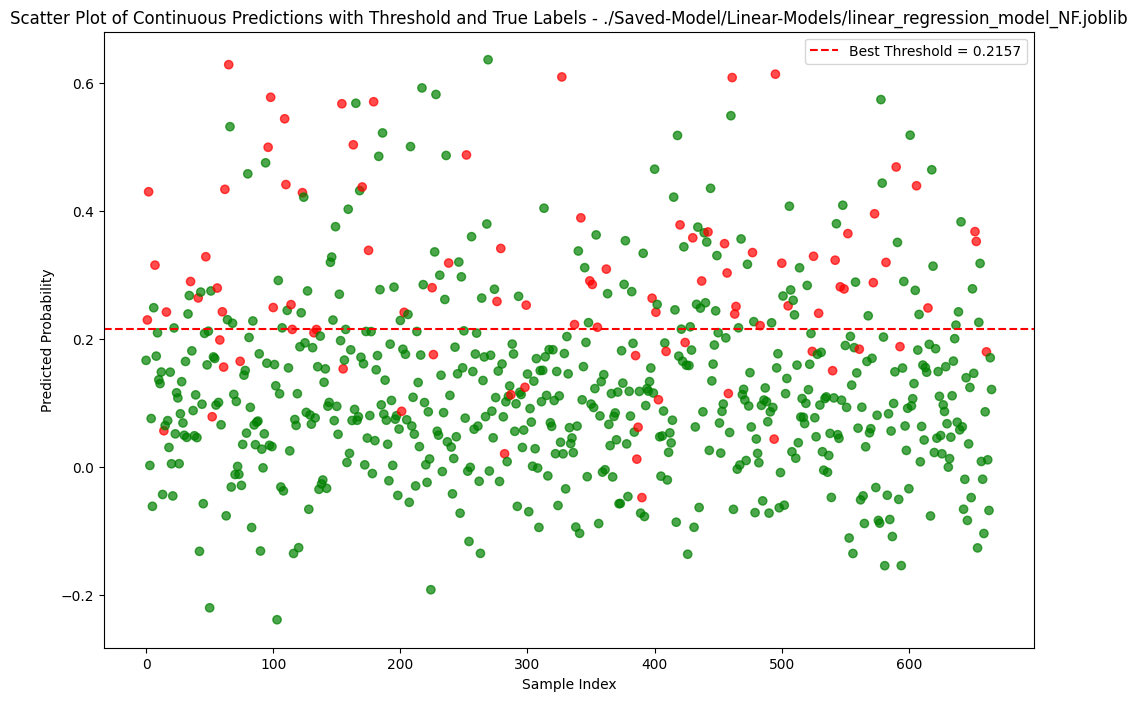

Model: ./Saved-Model/Linear-Models/gradient_regression_model_NF.joblib
ROC AUC: 0.82
Confusion Matrix:
 [[466 105]
 [ 29  66]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.87       571
           1       0.39      0.69      0.50        95

    accuracy                           0.80       666
   macro avg       0.66      0.76      0.69       666
weighted avg       0.86      0.80      0.82       666



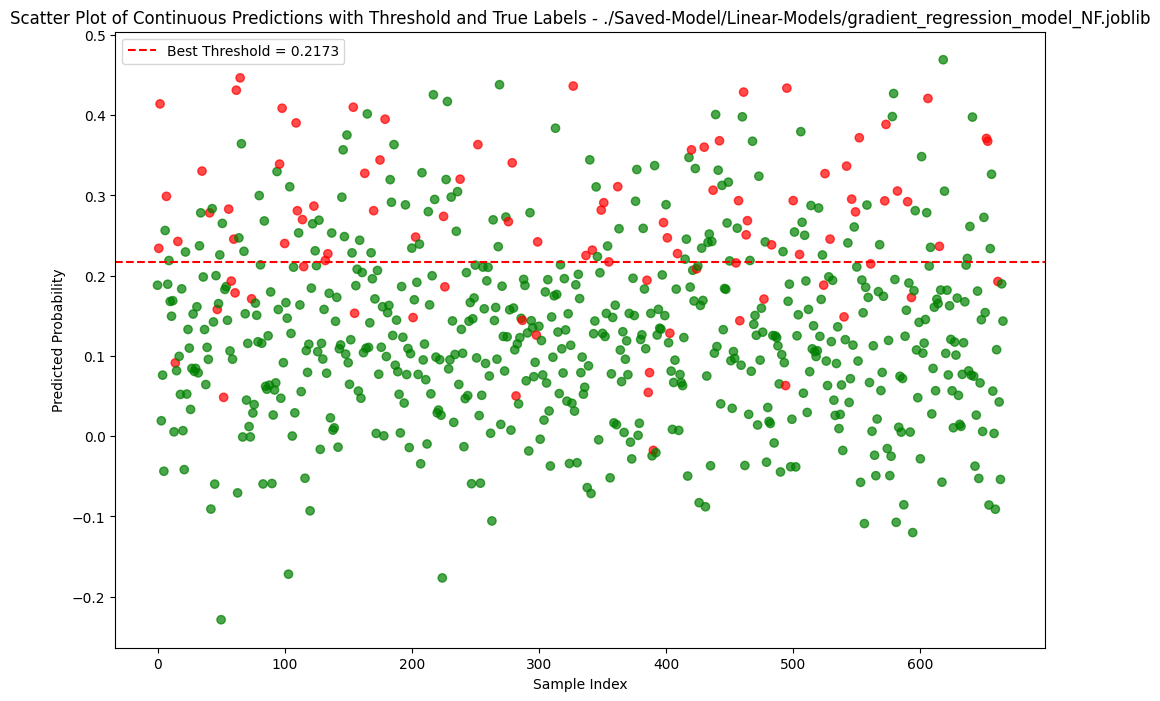

In [12]:
models_NF = load_models_and_thresholds('./Saved-Model/Linear-Models/model_info.csv', filter_keyword='_NF')

for model_filename, threshold in models_NF.items():
    predictions = predict_linear_with_threshold_and_evaluate(X_validation_NF[0:-1],y_val_actual_NF[0:-1], model_filename, threshold)

## With Feature Engineering

Model: ./Saved-Model/Linear-Models/linear_regression_model_F.joblib
ROC AUC: 0.88
Confusion Matrix:
 [[513  58]
 [ 31  64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       571
           1       0.52      0.67      0.59        95

    accuracy                           0.87       666
   macro avg       0.73      0.79      0.76       666
weighted avg       0.88      0.87      0.87       666



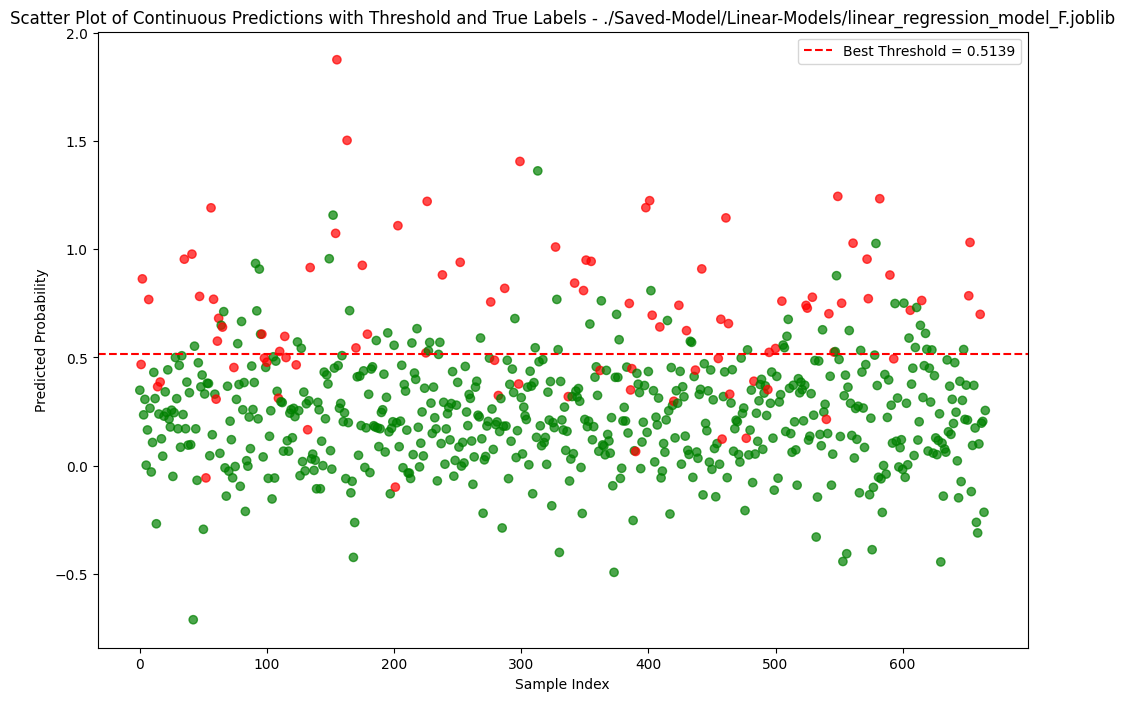

Model: ./Saved-Model/Linear-Models/gradient_regression_model_F.joblib
ROC AUC: 0.80
Confusion Matrix:
 [[406 165]
 [ 24  71]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.71      0.81       571
           1       0.30      0.75      0.43        95

    accuracy                           0.72       666
   macro avg       0.62      0.73      0.62       666
weighted avg       0.85      0.72      0.76       666



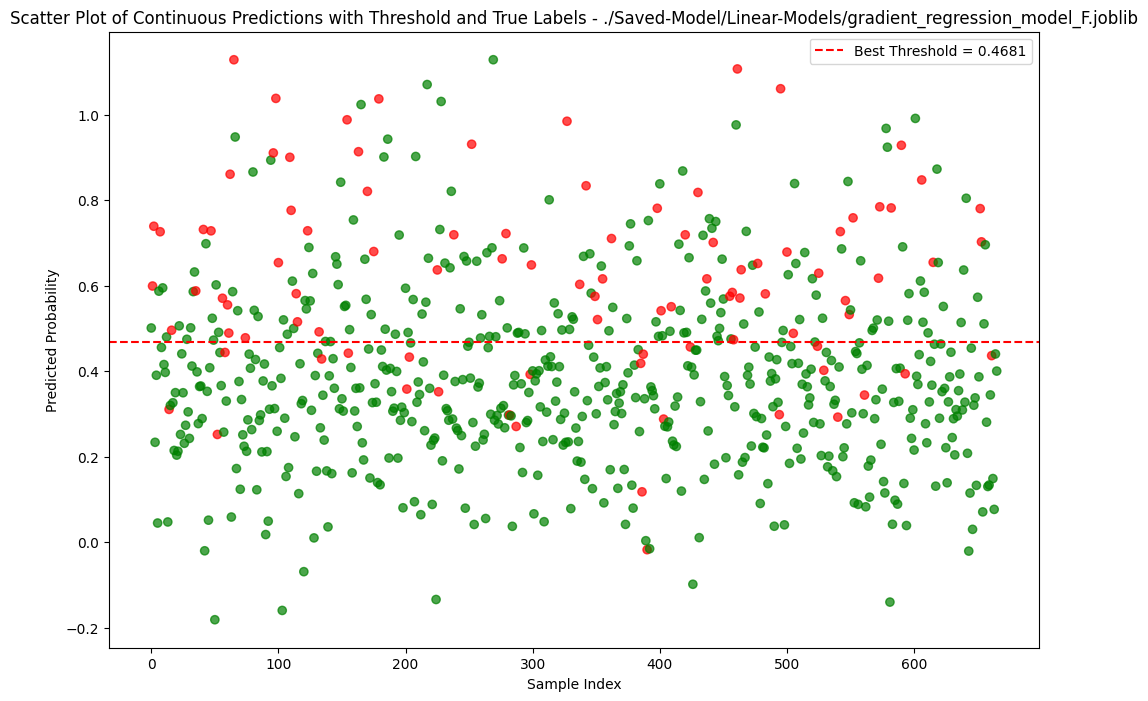

In [13]:
models_F = load_models_and_thresholds('./Saved-Model/Linear-Models/model_info.csv', filter_keyword='_F')

for model_filename, threshold in models_F.items():
    predictions = predict_linear_with_threshold_and_evaluate(X_validation_F[0:-1],y_val_actual_F[0:-1], model_filename, threshold)

# Classification Models

## Without Feature Engineering

Model: ./Saved-Model/Logistic-Models/logistic_regression_model_NF.joblib
ROC AUC: 0.83
Confusion Matrix:
 [[492  79]
 [ 39  56]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89       571
           1       0.41      0.59      0.49        95

    accuracy                           0.82       666
   macro avg       0.67      0.73      0.69       666
weighted avg       0.85      0.82      0.84       666



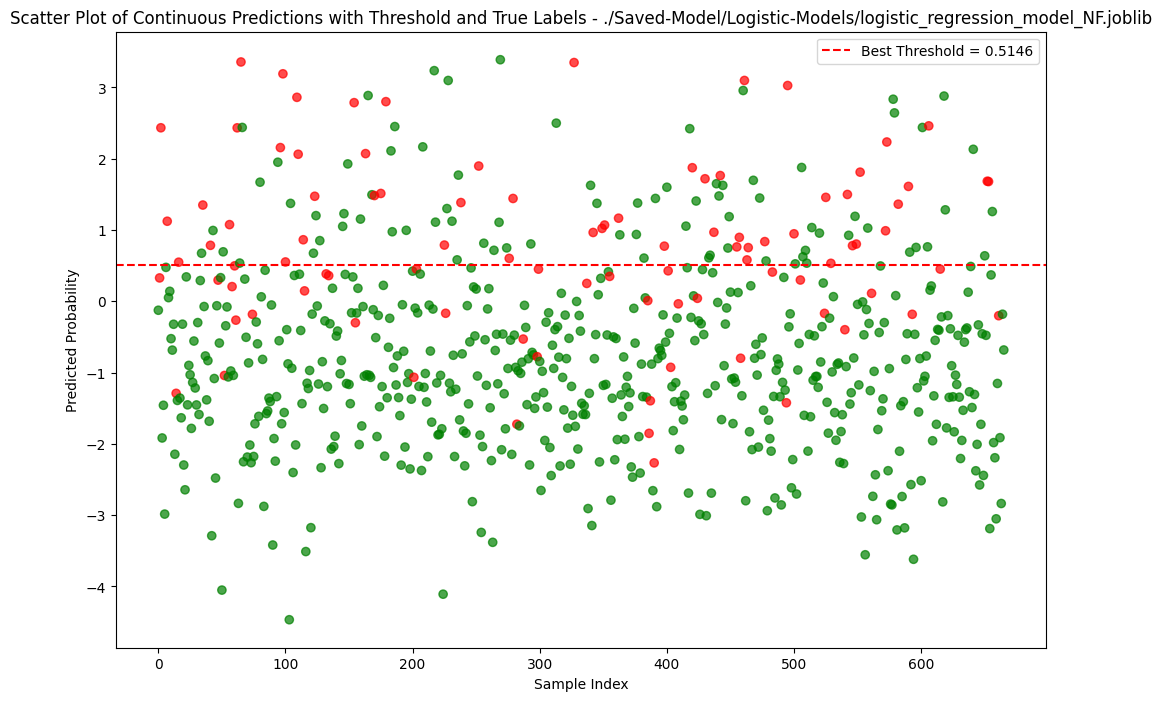

Model: ./Saved-Model/Logistic-Models/SGD_regression_model_NF.joblib
ROC AUC: 0.76
Confusion Matrix:
 [[510  61]
 [ 57  38]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90       571
           1       0.38      0.40      0.39        95

    accuracy                           0.82       666
   macro avg       0.64      0.65      0.64       666
weighted avg       0.83      0.82      0.82       666



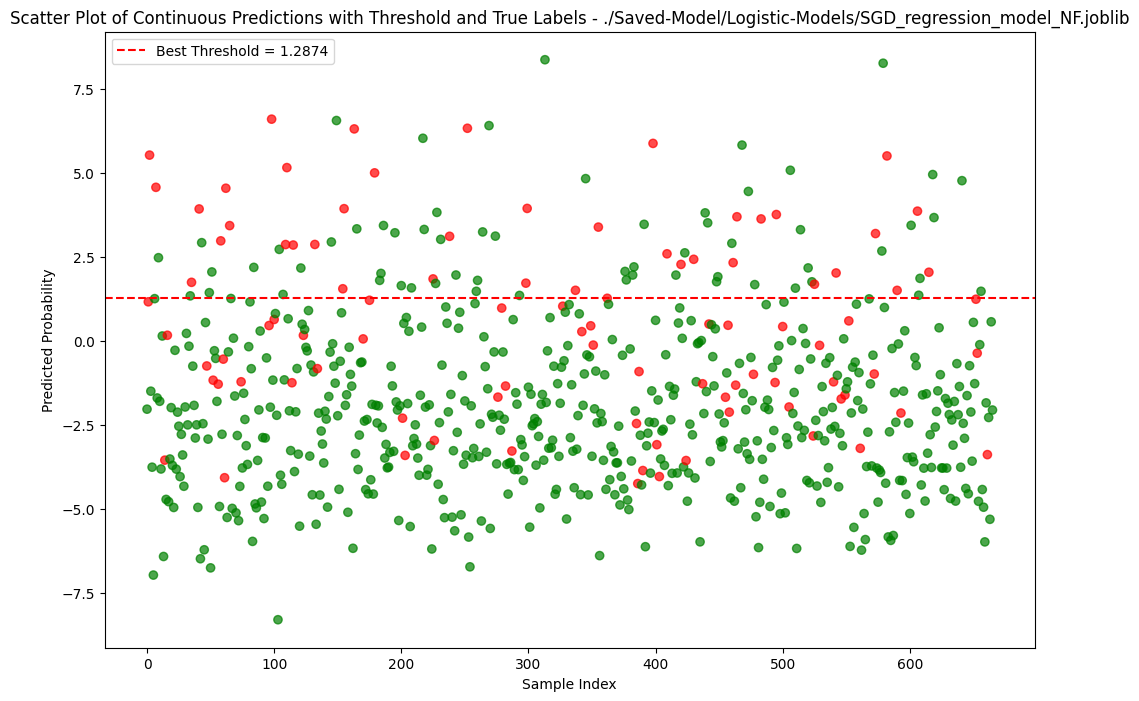

In [14]:
models_NF = load_models_and_thresholds('./Saved-Model/Logistic-Models/model_info.csv', filter_keyword='_NF')

for model_filename, threshold in models_NF.items():
    predictions = predict_logistic_with_threshold_and_evaluate(X_validation_NF[0:-1],y_val_actual_NF[0:-1], model_filename, threshold)

## With Feature Engineering

Model: ./Saved-Model/Logistic-Models/logistic_regression_model_F.joblib
ROC AUC: 0.88
Confusion Matrix:
 [[538  33]
 [ 34  61]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       571
           1       0.65      0.64      0.65        95

    accuracy                           0.90       666
   macro avg       0.79      0.79      0.79       666
weighted avg       0.90      0.90      0.90       666



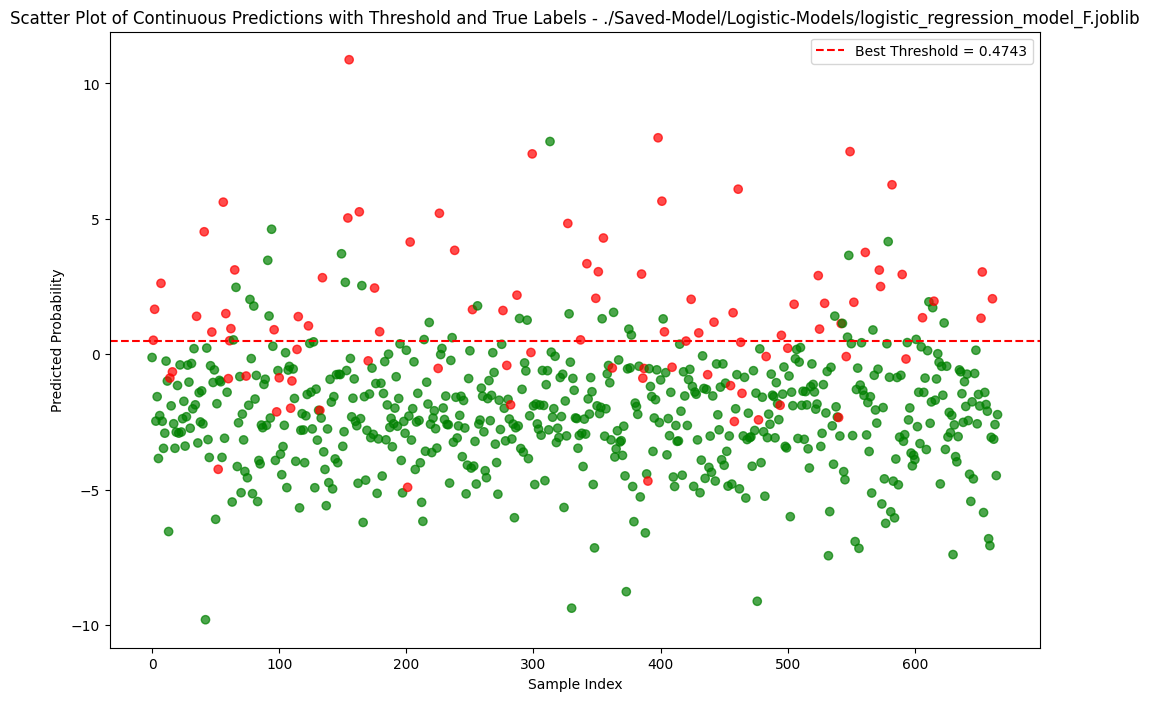

Model: ./Saved-Model/Logistic-Models/SGD_regression_model_F.joblib
ROC AUC: 0.84
Confusion Matrix:
 [[491  80]
 [ 24  71]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90       571
           1       0.47      0.75      0.58        95

    accuracy                           0.84       666
   macro avg       0.71      0.80      0.74       666
weighted avg       0.88      0.84      0.86       666



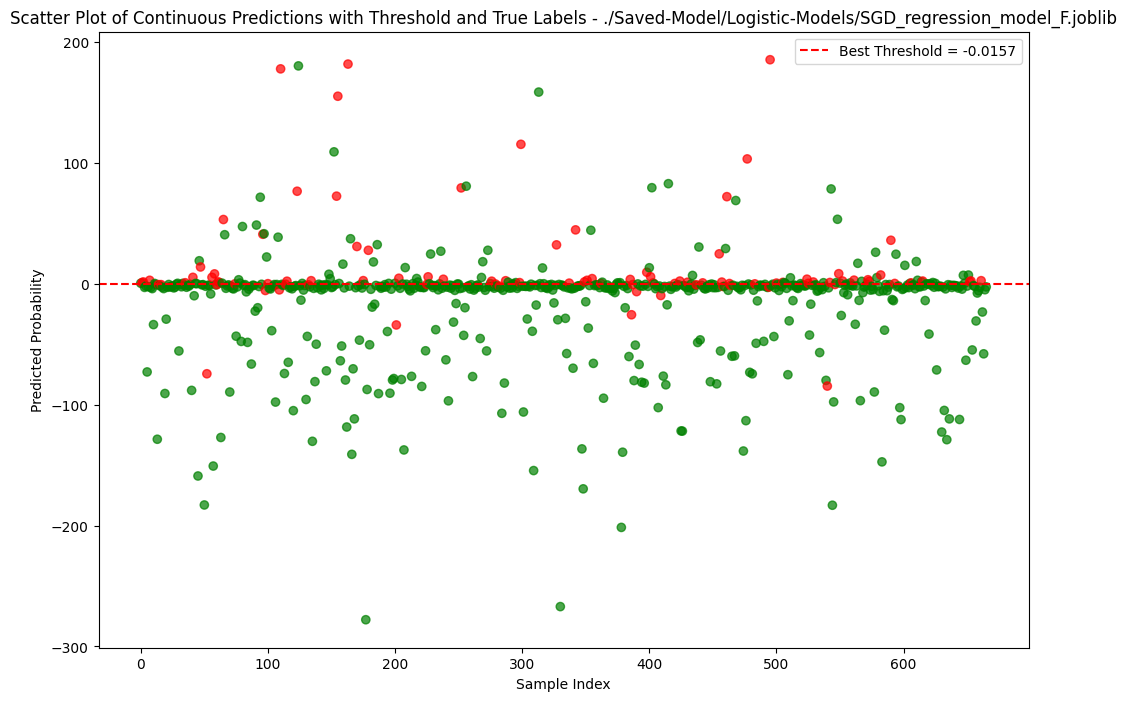

In [15]:
models_F = load_models_and_thresholds('./Saved-Model/Logistic-Models/model_info.csv', filter_keyword='_F')
for model_filename, threshold in models_F.items():
    predictions = predict_logistic_with_threshold_and_evaluate(X_validation_F[0:-1],y_val_actual_F[0:-1], model_filename, threshold)

# DecisionTree Model

## Without Feature Engineering

Model: ./Saved-Model/DecisionTree-Models/DecisionTree_model_NF.joblib
ROC AUC: 0.81
Confusion Matrix:
 [[537  34]
 [ 31  64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       571
           1       0.65      0.67      0.66        95

    accuracy                           0.90       666
   macro avg       0.80      0.81      0.80       666
weighted avg       0.90      0.90      0.90       666



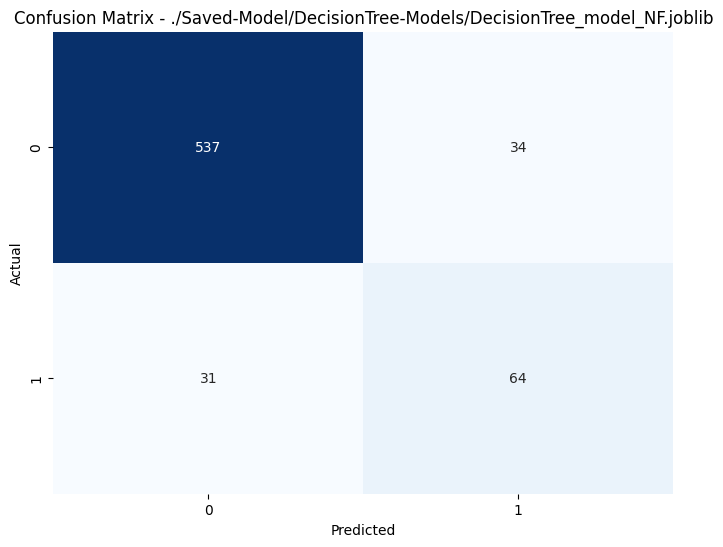

In [16]:
# Assuming X_test and y_test are your test data
model_filename_decision_tree = './Saved-Model/DecisionTree-Models/DecisionTree_model_NF.joblib'

y_pred_decision_tree = predict_decision_tree_and_evaluate(X_validation_NF[0:-1], y_val_actual_NF[0:-1], model_filename_decision_tree)


## With Feature Engineering

Model: ./Saved-Model/DecisionTree-Models/DecisionTree_model_F.joblib
ROC AUC: 0.88
Confusion Matrix:
 [[523  48]
 [ 14  81]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94       571
           1       0.63      0.85      0.72        95

    accuracy                           0.91       666
   macro avg       0.80      0.88      0.83       666
weighted avg       0.92      0.91      0.91       666



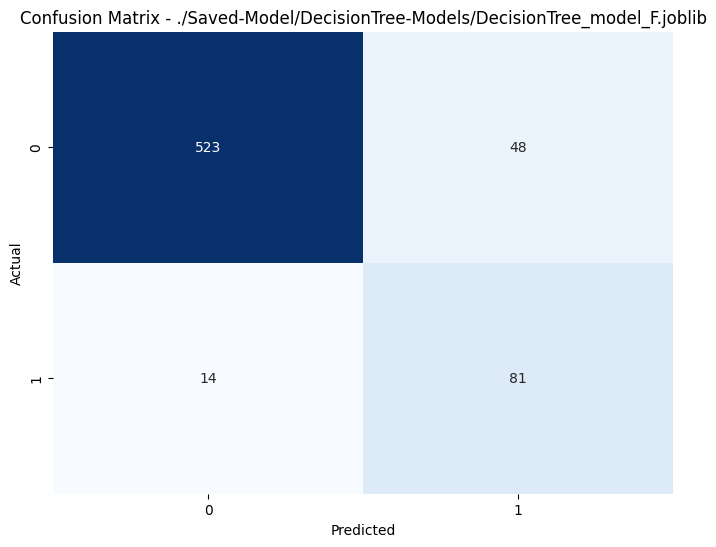

In [17]:
model_filename_decision_tree = './Saved-Model/DecisionTree-Models/DecisionTree_model_F.joblib'

y_pred_decision_tree = predict_decision_tree_and_evaluate(X_validation_F[0:-1], y_val_actual_F[0:-1], model_filename_decision_tree)

# XGBoast

## Without Feature Engineering

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       571
           1       0.94      0.79      0.86        95

    accuracy                           0.96       666
   macro avg       0.95      0.89      0.92       666
weighted avg       0.96      0.96      0.96       666



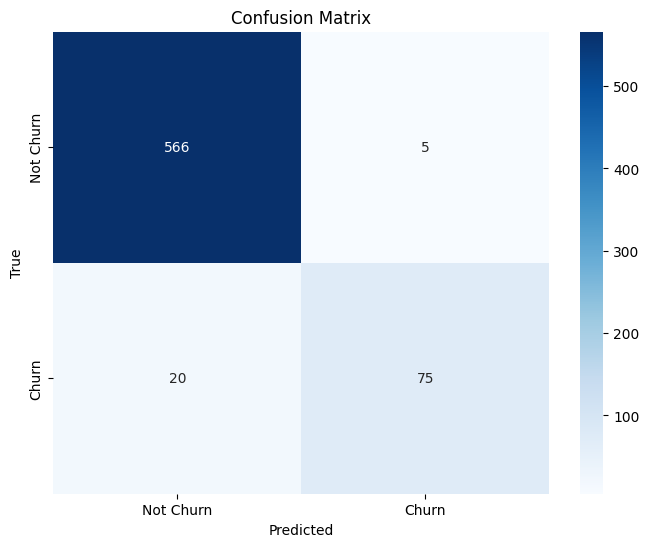

In [18]:
model_filename_XGBoast = './Saved-Model/XGBoast-Models/XGBoast_model_NF.joblib'

y_pred_XGBoast = predict_xgboost_and_evaluate(X_validation_NF[0:-1], y_val_actual_NF[0:-1], model_filename_XGBoast)

## With Feature Engineering

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       571
           1       0.95      0.87      0.91        95

    accuracy                           0.98       666
   macro avg       0.97      0.93      0.95       666
weighted avg       0.98      0.98      0.98       666



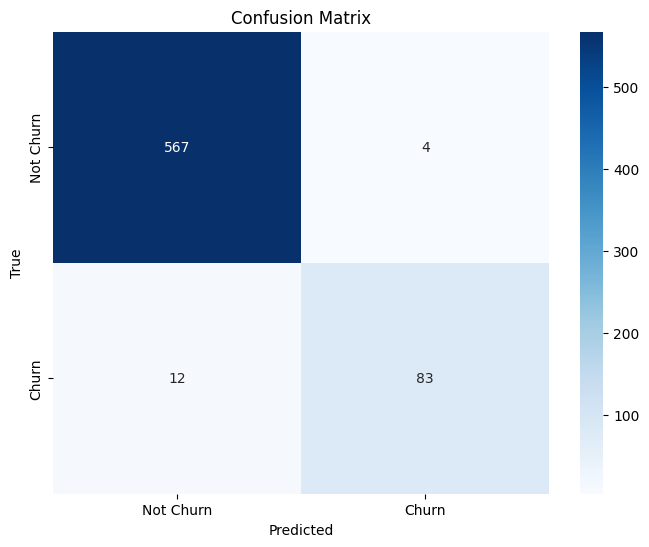

In [19]:
model_filename_XGBoast = './Saved-Model/XGBoast-Models/XGBoast_model_F.joblib'

y_pred_XGBoast = predict_xgboost_and_evaluate(X_validation_F[0:-1], y_val_actual_F[0:-1], model_filename_XGBoast)

# Naural Network Model

### Without Feature Egineering

In [20]:
X_val_scaled_loaded_NF = np.loadtxt("../Data/Clean-Data/X_validation_NF.csv", delimiter=",")
X_val_scaled_loaded_F = np.loadtxt("../Data/Clean-Data/X_validation_F.csv", delimiter=",")

2024-02-07 15:30:25.427136: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-07 15:30:25.427627: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


21/21 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       571
           1       0.87      0.73      0.79        95

    accuracy                           0.95       666
   macro avg       0.91      0.85      0.88       666
weighted avg       0.94      0.95      0.94       666



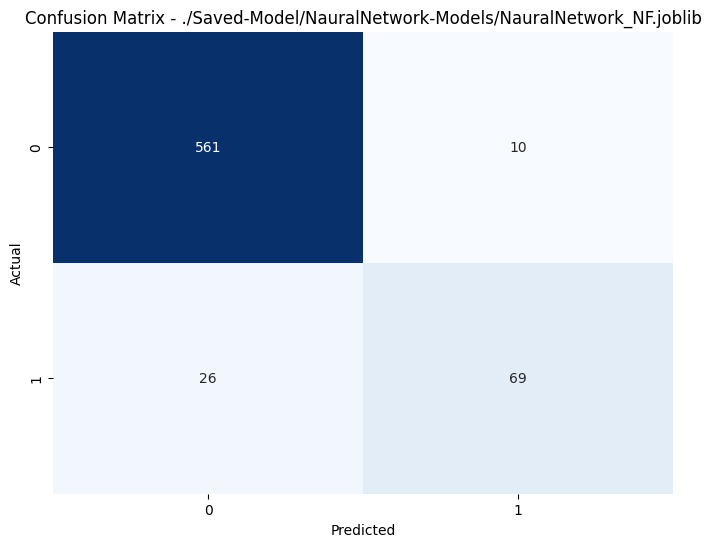

In [21]:
model_filename_XGBoast = './Saved-Model/NauralNetwork-Models/NauralNetwork_NF.joblib'

y_pred_ann = predict_ANN_and_evaluate(X_val_scaled_loaded_NF[0:-1], y_val_actual_NF[0:-1], model_filename_XGBoast)

### With Feature Engineering

21/21 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       571
           1       0.70      0.80      0.75        95

    accuracy                           0.92       666
   macro avg       0.83      0.87      0.85       666
weighted avg       0.93      0.92      0.93       666



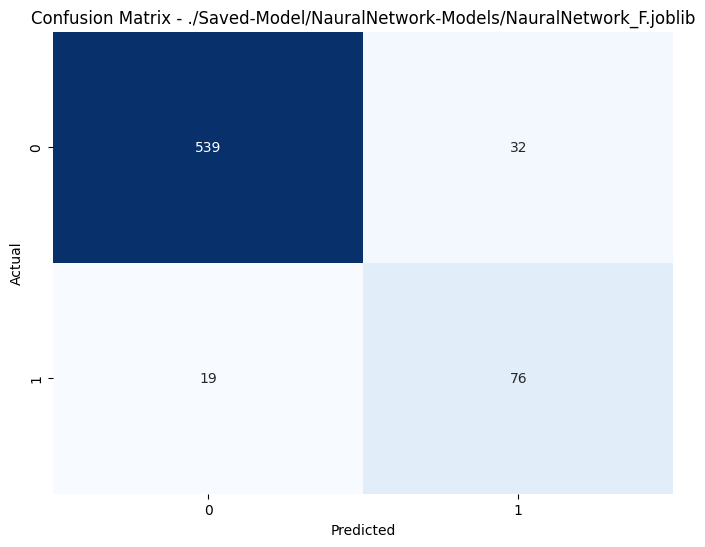

In [22]:
model_filename_XGBoast = './Saved-Model/NauralNetwork-Models/NauralNetwork_F.joblib'

y_pred_XGBoast = predict_ANN_and_evaluate(X_val_scaled_loaded_F[0:-1], y_val_actual_F[0:-1], model_filename_XGBoast)

# Random Forest

In [23]:
dataset_df_validation_NF=pd.concat([X_validation_NF,y_val_actual_NF],axis=1)
dataset_df_validation_F=pd.concat([X_validation_F,y_val_actual_F],axis=1)

### Without Feature Engineering

[INFO 24-02-07 15:30:26.5920 PKT kernel.cc:1233] Loading model from path ../Model-Notebooks/Saved-Model/RandomForest-Models/random_forest_model_NF/assets/ with prefix 97d0eede11654a0c
[INFO 24-02-07 15:30:26.7445 PKT decision_forest.cc:660] Model loaded with 300 root(s), 58728 node(s), and 19 input feature(s).
[INFO 24-02-07 15:30:26.7445 PKT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-02-07 15:30:26.7445 PKT kernel.cc:1061] Use fast generic engine


1/1 [==============================] - 0s 82ms/step
Confusion Matrix:
[[566   5]
 [ 26  69]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       571
           1       0.93      0.73      0.82        95

    accuracy                           0.95       666
   macro avg       0.94      0.86      0.89       666
weighted avg       0.95      0.95      0.95       666



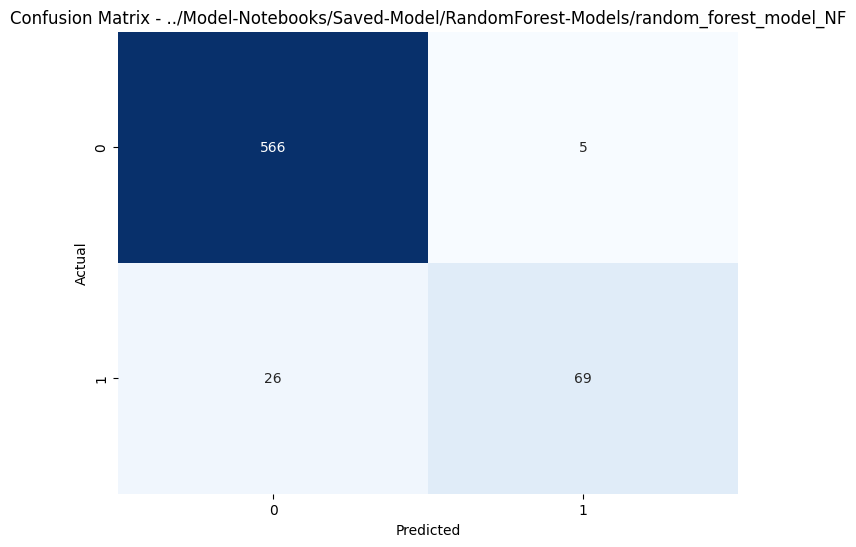

In [24]:
model_path='../Model-Notebooks/Saved-Model/RandomForest-Models/random_forest_model_NF'
random_forest_evaluate_model(model_path, dataset_df_validation_NF.iloc[0:-1], "Churn")


### With Feature Engineering

In [25]:
dataset_df_validation_F.iloc[2]

State                      34.00
Account length            161.00
Area code                 415.00
International plan          0.00
Voice mail plan             0.00
Number vmail messages       0.00
Total day minutes         332.90
Total day calls            67.00
Total eve minutes         317.80
Total eve calls            97.00
Total night minutes       160.60
Total night calls         128.00
Total intl minutes          5.40
Total intl calls            9.00
Customer service calls      4.00
Total charge               92.29
Churn                       1.00
Name: 2, dtype: float64

[INFO 24-02-07 15:30:27.1293 PKT kernel.cc:1233] Loading model from path ../Model-Notebooks/Saved-Model/RandomForest-Models/random_forest_model_F/assets/ with prefix 3a68832f71374110


[INFO 24-02-07 15:30:27.3583 PKT decision_forest.cc:660] Model loaded with 300 root(s), 81624 node(s), and 16 input feature(s).
[INFO 24-02-07 15:30:27.3583 PKT kernel.cc:1061] Use fast generic engine


1/1 [==============================] - 0s 80ms/step
Confusion Matrix:
[[569   2]
 [ 13  82]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       571
           1       0.98      0.86      0.92        95

    accuracy                           0.98       666
   macro avg       0.98      0.93      0.95       666
weighted avg       0.98      0.98      0.98       666



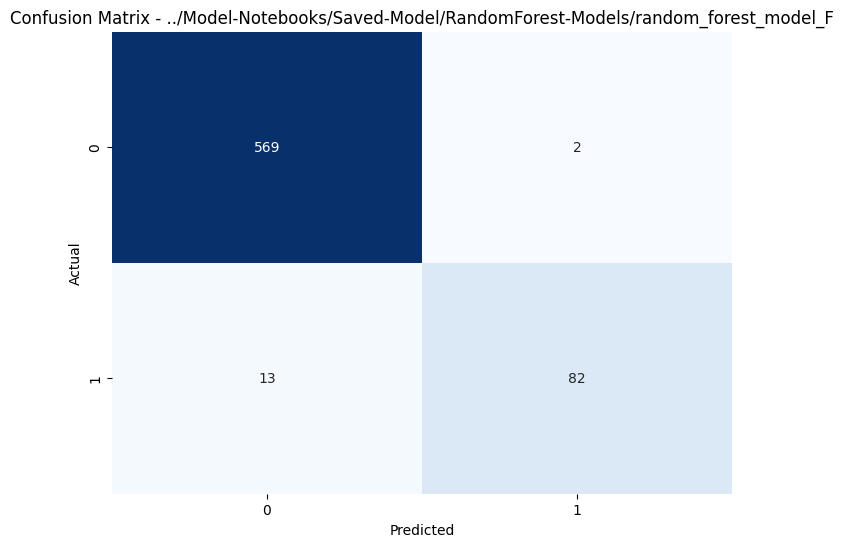

In [26]:
model_path='../Model-Notebooks/Saved-Model/RandomForest-Models/random_forest_model_F'

random_forest_evaluate_model(model_path, dataset_df_validation_F.iloc[0:-1], "Churn")